In [303]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from matplotlib import cm

In [304]:
def load_tsv(filename: str) -> pd.DataFrame:
    return pd.read_csv(filename, header=0, sep="\t")

def load_csv(filename: str) -> pd.DataFrame:
    return pd.read_csv(filename)

In [305]:
# We load both eye tracking data and self-paced reading time data
# and merge the two dataframes

frank_ET = load_tsv("../../frank/eyetracking.RT.txt").dropna(subset=["subj_nr", "sent_nr", "word_pos"])
frank_SP = load_tsv("../../frank/selfpacedreading.RT.txt").dropna(subset=["subj_nr", "sent_nr", "word_pos"])
frank_SP["subj_nr"] = -frank_SP["subj_nr"]

# We include entries for which we have only SP or only ET data
frank_both = frank_ET.merge(frank_SP, how="outer", on=["subj_nr", "word_pos", "sent_nr", "word", "sent_pos", "correct", "answer_time"])
frank_both["word_pos"] -= 1

# Function to aggregate the metrics for each token (over participants)
def make_grouped(df: pd.DataFrame, sent_col: str = "sent_nr", word_col: str = "word_pos") -> pd.DataFrame:
    return df.groupby(
        [sent_col, word_col]).mean(numeric_only=True).reset_index()

frank_both_grouped = make_grouped(frank_both)

In [306]:
# Functions to generate coloured scatterplots

def hex_to_RGB(hex_str):
    """ #FFFFFF -> [255,255,255]"""
    #Pass 16 to the integer function for change of base
    return [int(hex_str[i:i+2], 16) for i in range(1,6,2)]


def get_color_gradient(c1, c2, n):
    """
    Given two hex colors, returns a color gradient
    with n colors.
    """
    assert n > 1
    c1_rgb = np.array(hex_to_RGB(c1))/255
    c2_rgb = np.array(hex_to_RGB(c2))/255
    mix_pcts = [x/(n-1) for x in range(n)]
    rgb_colors = [((1-mix)*c1_rgb + (mix*c2_rgb)) for mix in mix_pcts]
    return ["#" + "".join([format(int(round(val*255)), "02x") for val in item]) for item in rgb_colors]

def scatterplot(
        df: pd.DataFrame, x: str, y: str, color_col: str = "word_pos", s: int = 5,
        *args, **kwargs) -> None:
    df = df.dropna(axis="index", subset=[x, y])
    fig, ax = plt.subplots()
    df.plot(
        ax=ax, kind="scatter", x=x, y=y,
        c=df[color_col], cmap=cm.coolwarm, s=s, *args, **kwargs)

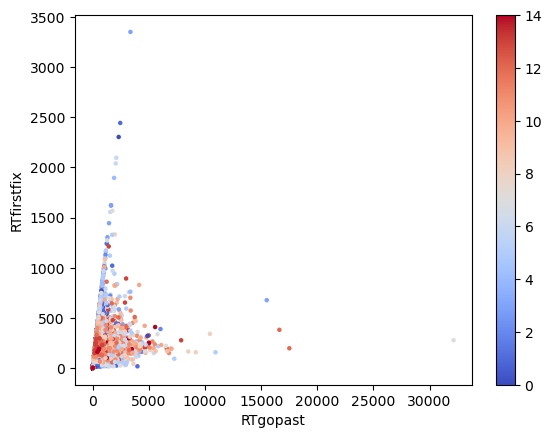

In [307]:
# We check how SPRT, FFD and GPT behave
# The colorbar refers to the position of a token in its sentence.

scatterplot(frank_both, "RTgopast", "RTfirstfix")

In [308]:
# Apparently, the further away a token is from the sentence beginning, the shorter its SPRT.
# For RT and GPT this is not so clear.

<Axes: xlabel='word_pos'>

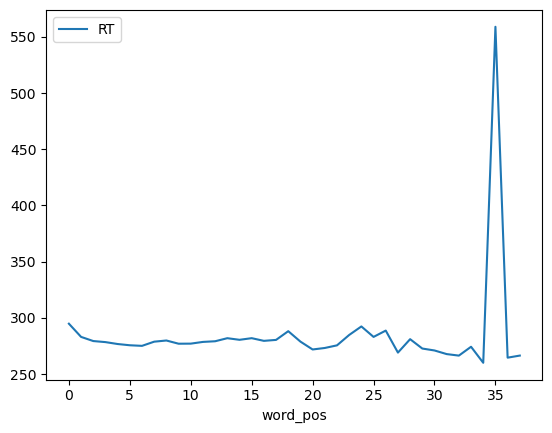

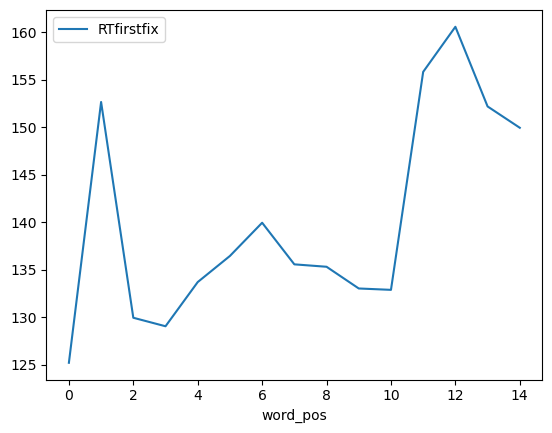

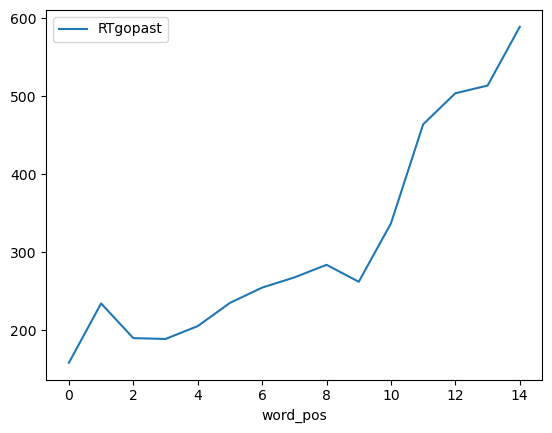

In [309]:
# Plot word position against RT metrics to see what relationship holds for FFD and GPT:

frank_both_grouped.groupby(["word_pos"]).mean(numeric_only=True).reset_index().plot(x="word_pos", y="RT")
frank_both_grouped.groupby(["word_pos"]).mean(numeric_only=True).reset_index().plot(x="word_pos", y="RTfirstfix")
frank_both_grouped.groupby(["word_pos"]).mean(numeric_only=True).reset_index().plot(x="word_pos", y="RTgopast")

In [310]:
# It seems like for FFD and GPT the opposite tendency holds: The further the
# sentence advances, the higher the metric.
# Only plot the sentences up to the length where ET data is available

<Axes: xlabel='word_pos'>

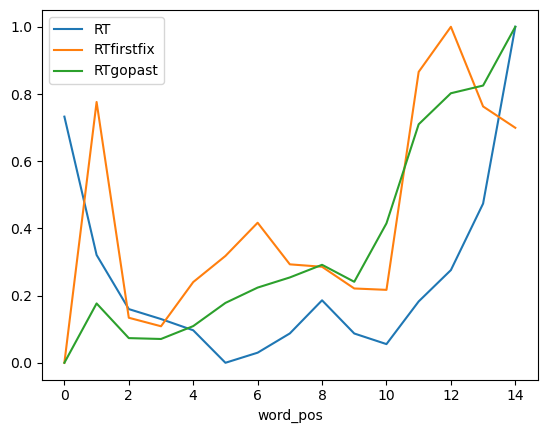

In [311]:
def minmaxnormalise(df: pd.DataFrame) -> pd.DataFrame:
    result = df.copy()
    for feature_name in df.columns:
        max_value = df[feature_name].max()
        min_value = df[feature_name].min()
        result[feature_name] = (df[feature_name] - min_value) / (max_value - min_value)
    return result

bins = np.arange(0, 11)/10

frank_both_grouped = frank_both_grouped.merge(frank_both_grouped.groupby('sent_nr')['word_pos'].max().reset_index().rename(columns={'word_pos': 'max_pos'}), on='sent_nr')

max_pos_ET = frank_both_grouped.dropna(subset=["RTfirstfix"])["max_pos"].max()
frank_both_grouped_uni = frank_both_grouped[frank_both_grouped["max_pos"] <= max_pos_ET]

minmaxnormalise(frank_both_grouped_uni.groupby(["word_pos"])[["RT", "RTfirstfix", "RTgopast"]].mean()).plot()

<Axes: xlabel='word_pos'>

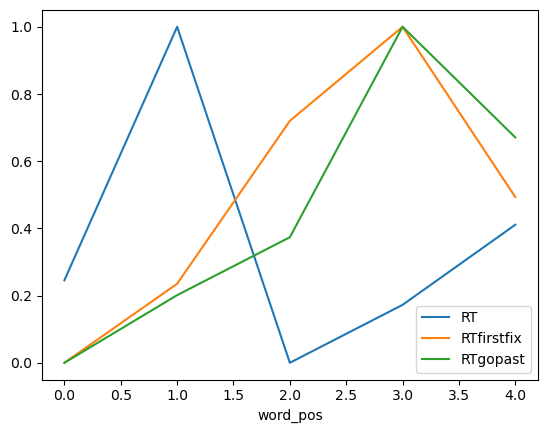

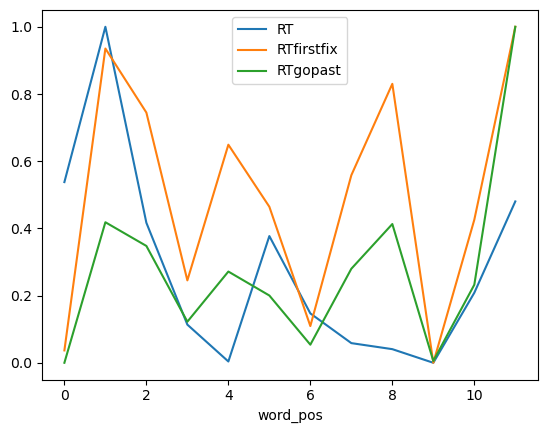

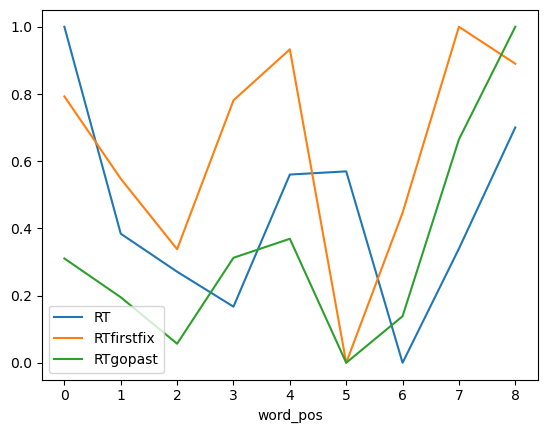

In [312]:
# Let's look at specific sentences

minmaxnormalise(frank_both_grouped_uni[frank_both_grouped_uni["sent_nr"] == 11][["RT", "RTfirstfix", "RTgopast", "word_pos"]].groupby("word_pos").mean(numeric_only=True)).plot()
minmaxnormalise(frank_both_grouped_uni[frank_both_grouped_uni["sent_nr"] == 150][["RT", "RTfirstfix", "RTgopast", "word_pos"]].groupby("word_pos").mean(numeric_only=True)).plot()
minmaxnormalise(frank_both_grouped_uni[frank_both_grouped_uni["sent_nr"] == 99][["RT", "RTfirstfix", "RTgopast", "word_pos"]].groupby("word_pos").mean(numeric_only=True)).plot()

<Axes: xlabel='word_pos'>

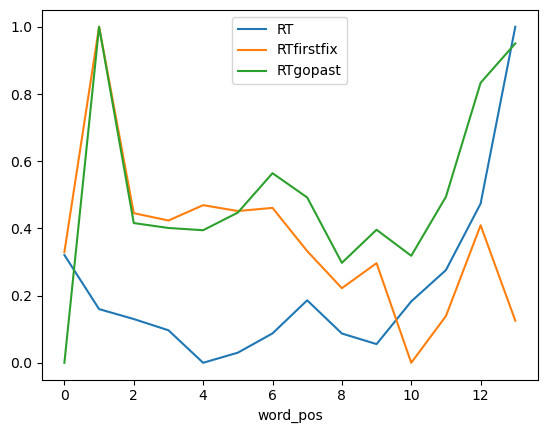

In [313]:
# Sooo... we seem to have a delay of 1 at RT. Let's shift RT by -1 steps
# and redraw the plots

grouped_by_sent = frank_both_grouped_uni.groupby("sent_nr")
temp = frank_both_grouped_uni.copy()
temp["sent_nr2"] = temp["sent_nr"]
shifted = temp.groupby("sent_nr2").shift(-1).dropna(subset=["sent_nr"])  #.groupby("sent_nr").apply(lambda group: group.iloc[1:]).droplevel(0)

def get_masker(to_remove):
    def make_mask(x):
        result = np.ones_like(x)
        result[to_remove] = 0
        return result
    return make_mask

mask = frank_both_grouped_uni.groupby("sent_nr")["sent_nr"].transform(get_masker(-1)).astype(bool)
dropped = frank_both_grouped_uni.loc[mask].copy()

dropped["RT"] = shifted["RT"]

minmaxnormalise(dropped.groupby(["word_pos"])[["RT", "RTfirstfix", "RTgopast"]].mean()).plot()


<Axes: xlabel='word_pos'>

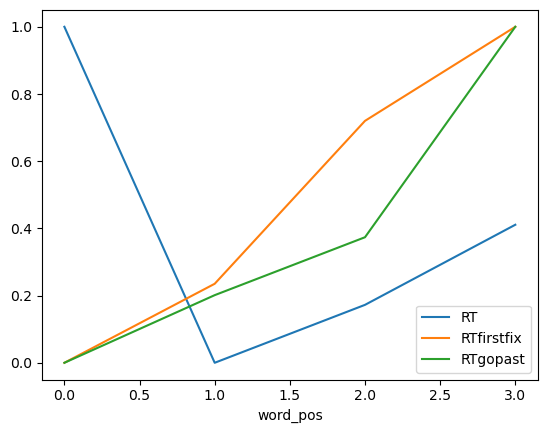

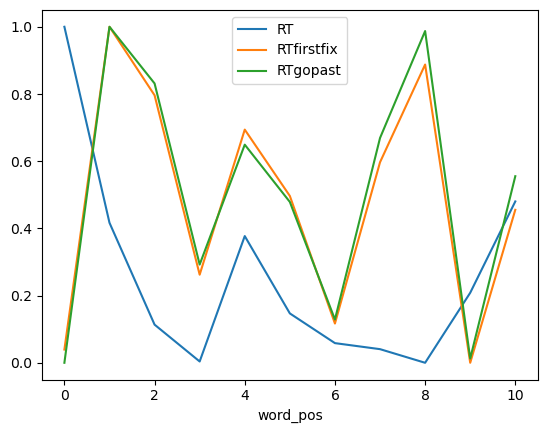

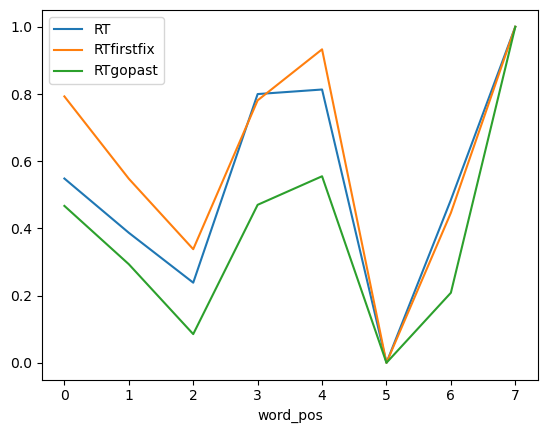

In [314]:
minmaxnormalise(dropped[dropped["sent_nr"] == 11][["RT", "RTfirstfix", "RTgopast", "word_pos"]].groupby("word_pos").mean(numeric_only=True)).plot()
minmaxnormalise(dropped[dropped["sent_nr"] == 150][["RT", "RTfirstfix", "RTgopast", "word_pos"]].groupby("word_pos").mean(numeric_only=True)).plot()
minmaxnormalise(dropped[dropped["sent_nr"] == 99][["RT", "RTfirstfix", "RTgopast", "word_pos"]].groupby("word_pos").mean(numeric_only=True)).plot()

In [315]:
# Let's compute correlations:

frank_both_grouped_uni[["RT", "RTfirstfix", "RTgopast"]].corr()

,RT,RTfirstfix,RTgopast
RT,1.000000,0.185433,0.277529
RTfirstfix,0.185433,1.000000,0.726045
RTgopast,0.277529,0.726045,1.000000


In [316]:
# Shifting RT back by one position

dropped[["RT", "RTfirstfix", "RTgopast"]].corr()

,RT,RTfirstfix,RTgopast
RT,1.000000,0.136576,0.204315
RTfirstfix,0.136576,1.000000,0.877265
RTgopast,0.204315,0.877265,1.000000


In [317]:
# Apparently, shifting made correlations worse.

In [318]:
# Cut off one token from the start
mask = dropped.groupby("sent_nr")["sent_nr"].transform(get_masker(0)).astype(bool)
dropped.loc[mask].copy()[["RT", "RTfirstfix", "RTgopast"]].corr()

,RT,RTfirstfix,RTgopast
RT,1.000000,0.139106,0.223387
RTfirstfix,0.139106,1.000000,0.874829
RTgopast,0.223387,0.874829,1.000000


In [319]:
# Cut off one token from the start and end of unshifted dataframe
mask = frank_both_grouped_uni.groupby("sent_nr")["sent_nr"].transform(get_masker([0, -1])).astype(bool)
frank_both_grouped_uni.loc[mask].copy()[["RT", "RTfirstfix", "RTgopast"]].corr()

,RT,RTfirstfix,RTgopast
RT,1.000000,0.095742,0.150340
RTfirstfix,0.095742,1.000000,0.874829
RTgopast,0.150340,0.874829,1.000000


In [320]:
# Well... that did not improve things...
# What about the other measures

In [321]:
frank_both_grouped_uni[["RT", "RTfirstfix", "RTgopast", "RTfirstpass", "RTrightbound"]].corr()

,RT,RTfirstfix,RTgopast,RTfirstpass,RTrightbound
RT,1.000000,0.185433,0.277529,0.228993,0.251170
RTfirstfix,0.185433,1.000000,0.726045,0.960626,0.936298
RTgopast,0.277529,0.726045,1.000000,0.755498,0.841875
RTfirstpass,0.228993,0.960626,0.755498,1.000000,0.974607
RTrightbound,0.251170,0.936298,0.841875,0.974607,1.000000


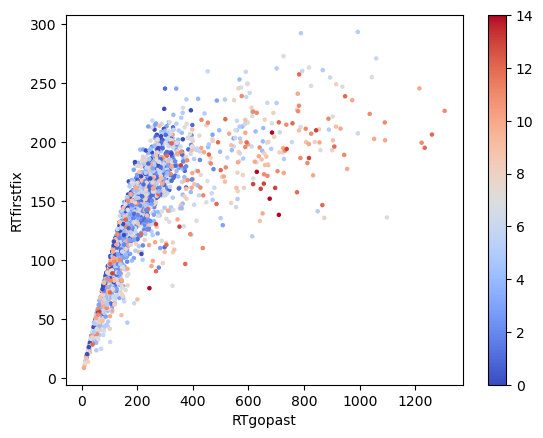

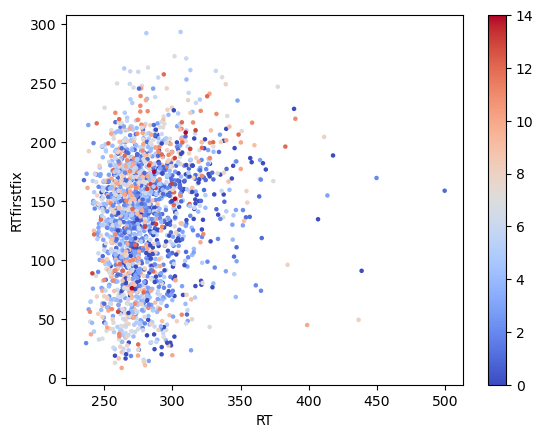

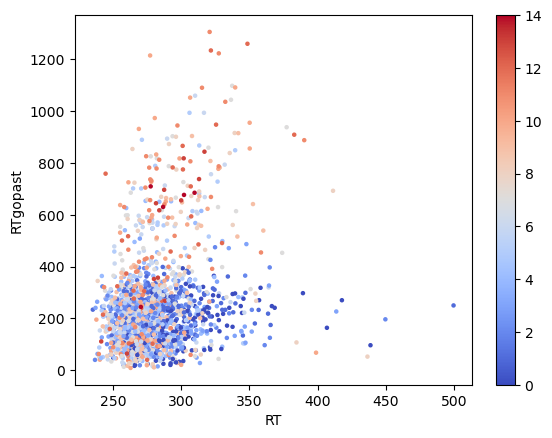

In [322]:
scatterplot(frank_both_grouped_uni, "RTgopast", "RTfirstfix")
scatterplot(frank_both_grouped_uni, "RT", "RTfirstfix")
scatterplot(frank_both_grouped_uni, "RT", "RTgopast")

In [323]:
# There seem to be some systematic outliers. Are these the sentence ends?
# We need to plot them in the same colour to see this. 

In [324]:
# Therefore, we define a separate colour range for each sentence, painting
# the beginning of each sentence blue and the last item red.

from matplotlib import ticker

def scatterplot_2(
        df: pd.DataFrame, x: str, y: str, color_col: str = "word_pos", sent_col: str = "sent_nr", s: int = 5,
        *args, **kwargs) -> None:
    df = df.dropna(axis="index", subset=[x, y])
    fig, ax = plt.subplots()
    plot_colorbar = True
    for sent in df[sent_col].unique():
        sent_df = df[df[sent_col].eq(sent)].copy()
        max_pos = sent_df[color_col].max()
        sent_df["word_pos_perc"] = sent_df[color_col] / max_pos
        sent_df.plot(
            ax=ax, kind="scatter", x=x, y=y,
            c=sent_df["word_pos_perc"], cmap=cm.coolwarm, s=s, colorbar=plot_colorbar, *args, **kwargs)
        plot_colorbar = False
    cax = fig.get_axes()[1]
    labels = cax.get_yticklabels()
    step = 1/(len(labels)-1)
    cax.set_yticks(cax.get_yticks())
    cax.set_yticklabels(list(np.arange(0, 1+step, step)))



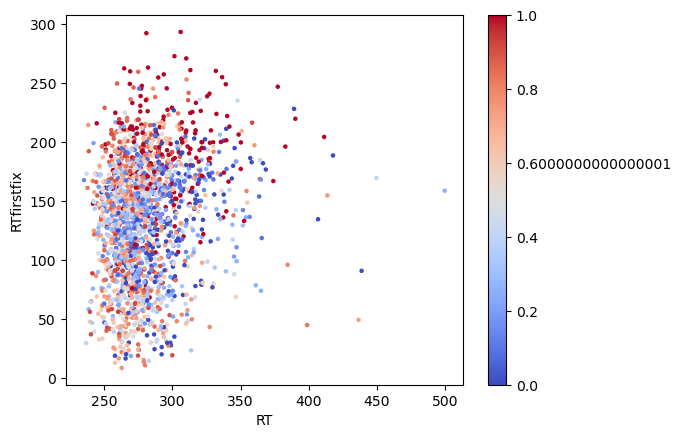

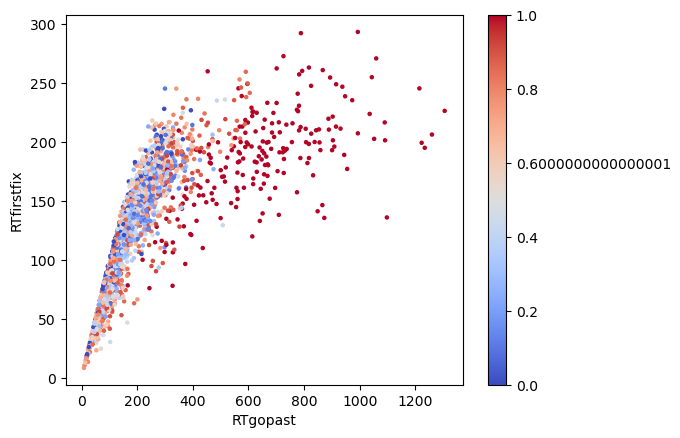

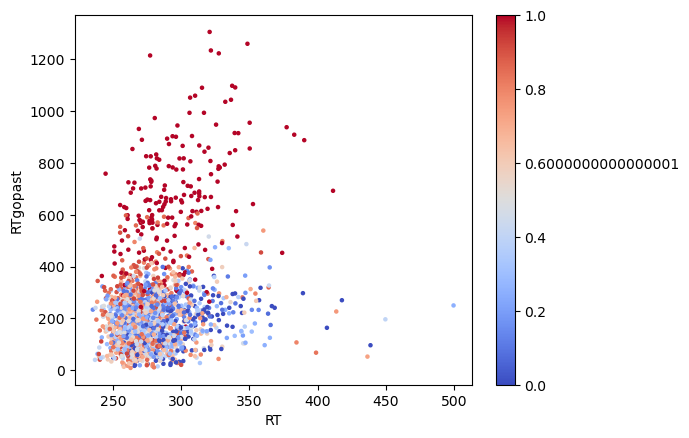

In [325]:
scatterplot_2(frank_both_grouped_uni, "RT", "RTfirstfix")
scatterplot_2(frank_both_grouped_uni, "RTgopast", "RTfirstfix")
scatterplot_2(frank_both_grouped_uni, "RT", "RTgopast")

/tmp/ipykernel_5300/549245265.py:13: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  temp = temp.groupby("binned_perc").mean(numeric_only=True).reset_index()


<Axes: xlabel='binned_perc'>

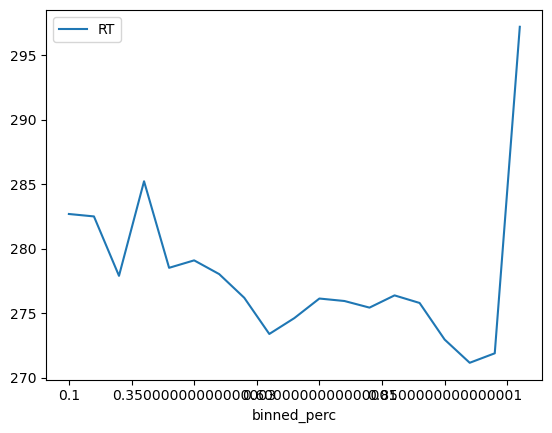

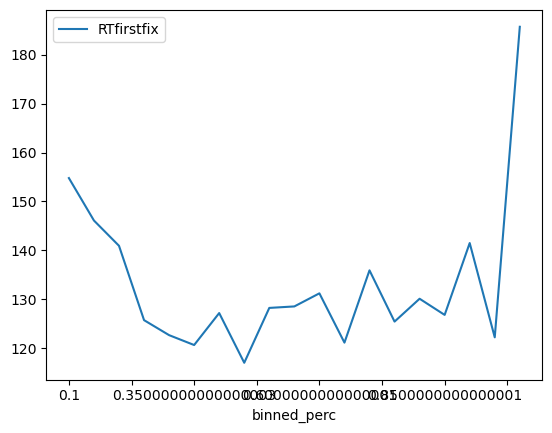

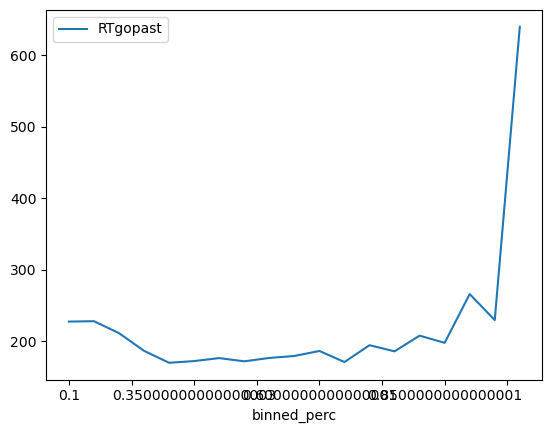

In [326]:
# Indeed, the last item in a sentence appears to exhibit a larger GPT than expected.

# Now we repeat the plot that shows position against RT metrics with position relative
# to overall sentence length

temp = frank_both_grouped_uni.copy()
temp["word_pos_perc"] = temp["word_pos"] / temp["max_pos"]

# We make bins
step_size = 0.05
bins = np.arange(0, 1+step_size, step_size)
temp["binned_perc"] = pd.cut(temp['word_pos_perc'], bins, labels=bins[1:])
temp = temp.groupby("binned_perc").mean(numeric_only=True).reset_index()

temp.dropna(subset=["RT"]).plot(x="binned_perc", y="RT")
temp.dropna(subset=["RTfirstfix"]).plot(x="binned_perc", y="RTfirstfix")
temp.dropna(subset=["RTgopast"]).plot(x="binned_perc", y="RTgopast")

In [327]:
# All three metrics experience a rise towards the end. For GPT this rise is around 6 times higher than the signal
# in other regions of the sentence. While in RT it is approximately as high as the signal in the beginning.
# This is probably the case because in ET the reader have access to the previous stimulus while in SP they do no

# So ideally we want to cut off the end because it corrodes our observational measures.

<Axes: xlabel='binned_perc'>

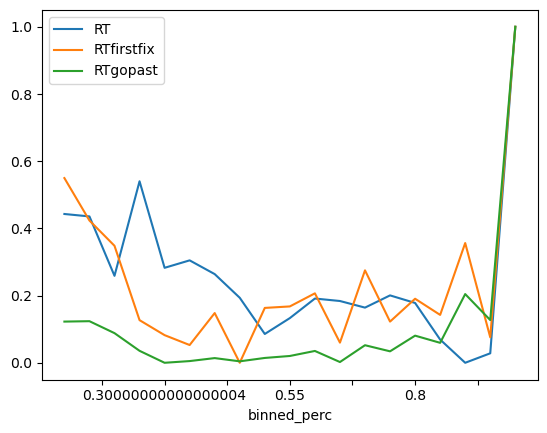

In [328]:
def minmaxnormalise(df: pd.DataFrame, ignore: set[str] = set()) -> pd.DataFrame:
    result = df.copy()
    for feature_name in df.columns:
        if not feature_name in ignore:
            max_value = df[feature_name].max()
            min_value = df[feature_name].min()
            result[feature_name] = (df[feature_name] - min_value) / (max_value - min_value)
    return result

minmaxnormalise(temp, ignore={"binned_perc"})[["binned_perc", "RT", "RTfirstfix", "RTgopast"]].plot(x="binned_perc")

In [342]:
# Now let's load data that dropped the very last and the first token in each sentence.
# Let's load only sentence of the length that occurs in both subsets (ET data has a lower limit) to not
# dilute a part of our evaluation

frank_SP2 = load_csv("../../RT/data/frank_SP_preprocessed_exp1_current_.10_0.csv").dropna(subset=["WorkerId", "item", "zone"])
frank_ET2 = load_csv("../../RT/data/frank_ET_preprocessed_exp1_current_.10_0.csv").dropna(subset=["WorkerId", "item", "zone"])
frank_ET2["WorkerId"] = -frank_ET2["WorkerId"]
frank_both2 = frank_ET2.merge(frank_SP2, how="outer", on=[
    "item", "zone", "WorkerId", "word", "length", "surprisal", "position", "expected_distance", "expected_distance.1", "expected_distance.2", "kl_divergence",
    "kl_divergence.1", "kl_divergence.2", "head_distance",
    "demberg", "predicted_first_dependent_distance", "first_dependent_distance", "first_dependent_distance.2", "first_dependent_correct", "first_dependent_distance_weight", "left_dependents_distance_sum",
    "left_dependents_count", "deprel", "pos", "first_dependent_deprel", "frequency", "surprisal.s", "frequency.s", "length.s", "demberg.1", "demberg.2", "surprisal.1", "surprisal.2"])

# Reduce zone by one so it starts from 1
frank_both2["zone"] -= 2

sent_max = frank_both2.groupby("item")["zone"].max().reset_index()
sent_max = sent_max.rename(columns={"zone": "zone_max"})

frank_both2 = frank_both2.merge(
    sent_max, on=["item"], how="inner")

frank_both2 = frank_both2[frank_both2["zone_max"] < frank_both2[~frank_both2["FFD"].isna()]["zone_max"].max()+1]
frank_both_grouped2 = make_grouped(frank_both2, sent_col="item", word_col="zone")

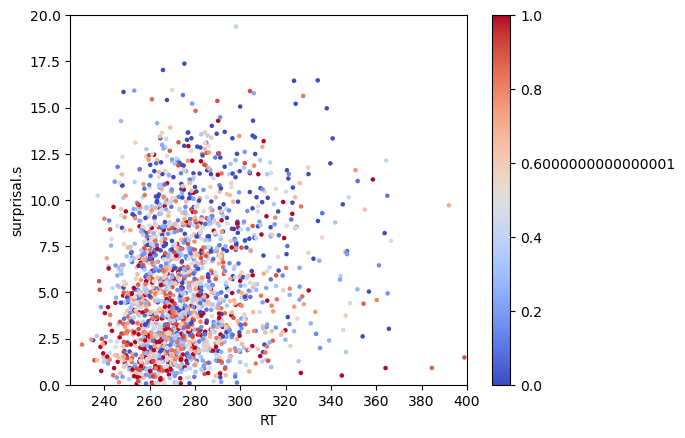

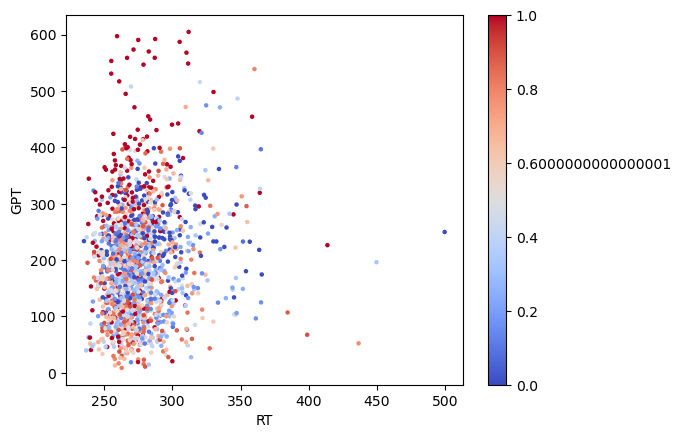

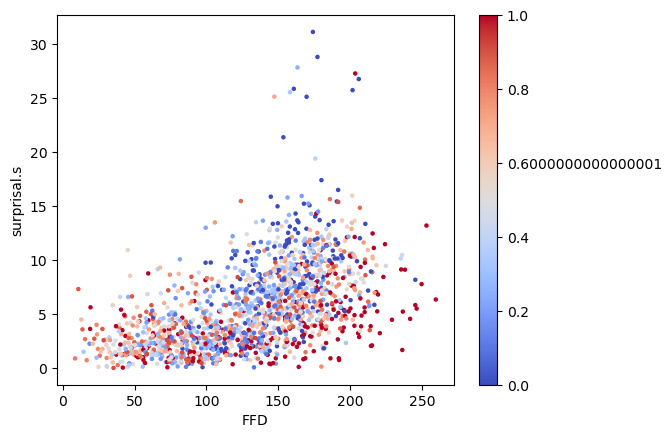

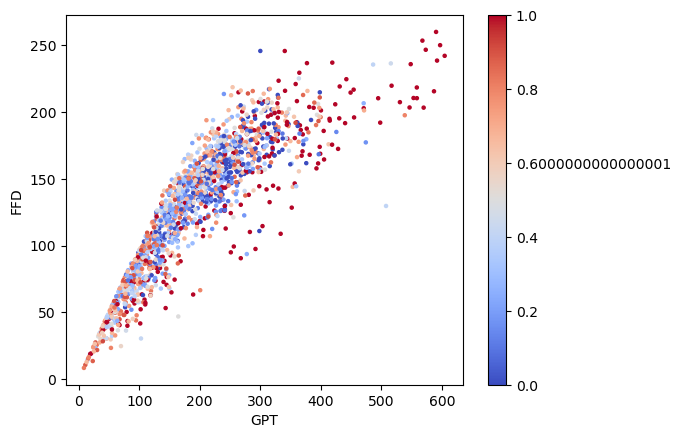

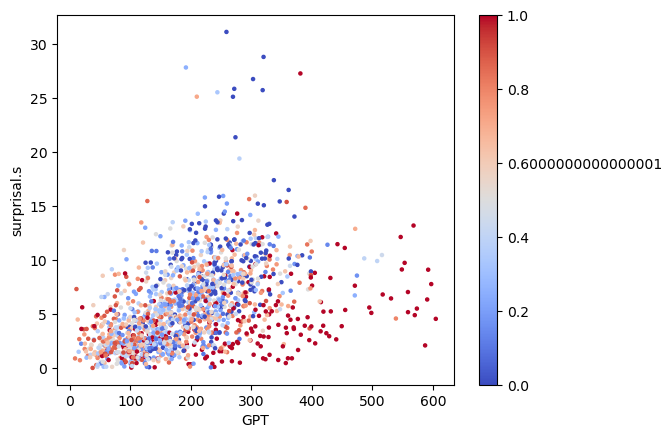

In [343]:
# Look at the plots given the data without first and last tokens

scatterplot_2(frank_both_grouped2, "RT", "surprisal.s", sent_col="item", color_col="zone", xlim=(225, 400), ylim=(0, 20))
scatterplot_2(frank_both_grouped2, "RT", "GPT", sent_col="item", color_col="zone")
scatterplot_2(frank_both_grouped2, "FFD", "surprisal.s", sent_col="item", color_col="zone")
scatterplot_2(frank_both_grouped2, "GPT", "FFD", sent_col="item", color_col="zone")
scatterplot_2(frank_both_grouped2, "GPT", "surprisal.s", sent_col="item", color_col="zone")

# TODO: Why is part of the colorbar white?

(0.0, 15.0)

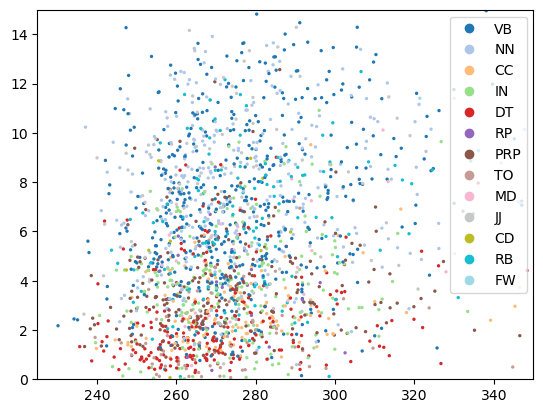

In [344]:
frank_both_grouped2["pos"] = frank_both2.groupby(["item", "zone"]).first().reset_index()["pos"]
pos_tags = frank_both_grouped2["pos"].unique()
pos2id = {pos: i for i, pos in enumerate(pos_tags)}
ids = [pos2id[pos] for pos in frank_both_grouped2["pos"]]

fig, ax = plt.subplots()
scatter = ax.scatter(frank_both_grouped2["RT"], frank_both_grouped2["surprisal.s"], s=2, c=ids, cmap=cm.tab20)
elements = scatter.legend_elements()[0]
legend = ax.legend(elements, pos_tags)
ax.set_xlim(225, 350)
ax.set_ylim(0,15)

(0.0, 15.0)

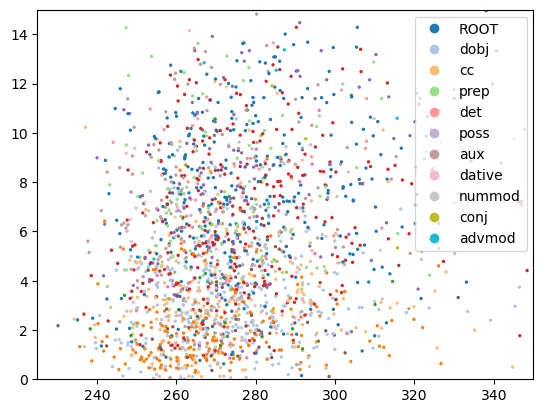

In [345]:
frank_both_grouped2["deprel"] = frank_both2.groupby(["item", "zone"]).first().reset_index()["deprel"]
pos_tags = frank_both_grouped2["deprel"].unique()
pos2id = {pos: i for i, pos in enumerate(pos_tags)}
ids = [pos2id[pos] for pos in frank_both_grouped2["deprel"]]

fig, ax = plt.subplots()
scatter = ax.scatter(frank_both_grouped2["RT"], frank_both_grouped2["surprisal.s"], s=2, c=ids, cmap=cm.tab20)
elements = scatter.legend_elements()[0]
legend = ax.legend(elements, pos_tags)
ax.set_xlim(225, 350)
ax.set_ylim(0,15)

In [382]:
# Rename columns so that they are easier to understand

frank_both2 = frank_both2.rename(columns={
    "surprisal": "surprisal",
    "surprisal.1": "surprisal+1",
    "surprisal.2": "surprisal-1",
    "demberg": "demberg",
    "demberg.1": "demberg+1",
    "demberg.2": "demberg-1",
})

In [383]:
# Check Pearson correlation coefficients between metrics and candidates

def get_proportional(frank_both2: pd.DataFrame) -> pd.DataFrame:
    frank_both_proportional2 = frank_both2.copy()
    frank_both_proportional2 = frank_both_proportional2.rename(columns={
        "surprisal": "surprisal",
        "surprisal.1": "surprisal+1",
        "surprisal.2": "surprisal-1",
        "demberg": "demberg",
        "demberg.1": "demberg+1",
        "demberg.2": "demberg-1",
        "left_dependents_count": "ldc",
        "left_dependents_distance_sum": "ldds",
        "kl_divergence": "kl",
        "kl_divergence.1": "kl+1",
        "kl_divergence.2": "kl-1",
        "expected_distance": "expd",
        "expected_distance.1": "expd+1",
        "expected_distance.2": "expd-1",
        "first_dependent_distance": "fdd",
        "first_dependent_distance.2": "fdd-1",
        "predicted_first_dependent_distance": "pfdd"
    })
    sent_max2 = frank_both_proportional2.groupby("item")["zone"].max().reset_index()
    sent_max2 = sent_max2.rename(columns={"zone": "zone_max2"})
    frank_both_proportional2 = frank_both_proportional2.merge(
        sent_max2, on=["item"], how="outer")
    frank_both_proportional2["percent_of_sent"] = frank_both_proportional2["zone"] / frank_both_proportional2["zone_max2"]
    return frank_both_proportional2


def make_left_(df: pd.DataFrame, col: str) -> None:
    df[df[col] > 0] = 0
    df[col] *= -1

frank_both_proportional2 = get_proportional(frank_both2)
make_left_(frank_both_proportional2, "fdd")
make_left_(frank_both_proportional2, "fdd-1")
make_left_(frank_both_proportional2, "pfdd")

frank_both_proportional2[["RT", "FFD", "GPT", "surprisal", "demberg", "frequency", "length", "position", "percent_of_sent"]].corr()

/tmp/ipykernel_5300/2328735185.py:33: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.
  df[df[col] > 0] = 0


,RT,FFD,GPT,surprisal,demberg,frequency,length,position,percent_of_sent
RT,1.000000,NaN,NaN,0.449705,0.222701,0.625705,0.527903,0.471249,0.459546
FFD,NaN,1.000000,0.695735,0.589059,0.370715,0.543408,0.652776,0.474358,0.487465
GPT,NaN,0.695735,1.000000,0.443286,0.276730,0.396070,0.488623,0.358963,0.384405
surprisal,0.449705,0.589059,0.443286,1.000000,0.506294,0.359910,0.774895,0.296102,0.279387
demberg,0.222701,0.370715,0.276730,0.506294,1.000000,0.083345,0.468760,0.203404,0.177322
frequency,0.625705,0.543408,0.396070,0.359910,0.083345,1.000000,0.523548,0.678430,0.666150
length,0.527903,0.652776,0.488623,0.774895,0.468760,0.523548,1.000000,0.433997,0.423484
position,0.471249,0.474358,0.358963,0.296102,0.203404,0.678430,0.433997,1.000000,0.889594
percent_of_sent,0.459546,0.487465,0.384405,0.279387,0.177322,0.666150,0.423484,0.889594,1.000000


In [350]:
# Check PCC after taking token-wise mean
# Also print spillover and prediction correlation

In [385]:
def print_table(df: pd.DataFrame, sep: str = ' & ', linesep: str = ' \\ ', round_to: None | int = 2) -> str:
    output = ""
    for line_num in range(len(df)):
        output += sep.join([df.iloc[line_num].name] + [str(value if round_to is None else round(value, round_to)) for value in df.iloc[line_num]])
        output += linesep
    return output

In [388]:

frank_both_proportional2["diff"] = frank_both_proportional2["GPT"] - frank_both_proportional2["RBT"]
to_correlate = ["diff", "RT", "FFD", "GPT", "RBT", "GD", "surprisal", "surprisal+1", "expd", "kl", "pfdd", "fdd", "ldds", "ldc", "demberg", "demberg+1", "demberg-1", "frequency", "length", "position"]
frank_both_proportional_grouped2 = make_grouped(frank_both_proportional2, sent_col="item", word_col="position") 
table = frank_both_proportional_grouped2[to_correlate].corr(method="pearson")
table

,diff,RT,FFD,GPT,RBT,GD,surprisal,surprisal+1,expd,kl,pfdd,fdd,ldds,ldc,demberg,demberg+1,demberg-1,frequency,length,position
diff,1.000000,0.106385,0.454084,0.801392,0.541533,0.468875,0.130990,-0.070734,-0.012330,0.015810,0.077610,0.060329,0.059096,0.100662,0.079717,-0.084819,0.015288,-0.126027,0.180965,0.103644
RT,0.106385,1.000000,0.088166,0.130482,0.121175,0.100867,0.151581,0.177391,0.009412,0.019562,0.016030,0.015360,0.012449,0.080192,0.047960,0.039239,-0.044379,-0.067430,0.153955,-0.096437
FFD,0.454084,0.088166,1.000000,0.872490,0.960721,0.975048,0.562615,-0.123671,0.114308,0.169194,0.336372,0.336454,0.319706,0.389158,0.386484,-0.205555,-0.185819,-0.657700,0.709675,-0.111667
GPT,0.801392,0.130482,0.872490,1.000000,0.936824,0.897479,0.466255,-0.104077,0.077400,0.131752,0.265221,0.256884,0.245854,0.320537,0.301313,-0.156739,-0.108289,-0.512252,0.580685,-0.026284
RBT,0.541533,0.121175,0.960721,0.936824,1.000000,0.987192,0.578712,-0.104913,0.115995,0.175930,0.327377,0.325767,0.310985,0.391643,0.376873,-0.170692,-0.161140,-0.646263,0.710316,-0.097555
GD,0.468875,0.100867,0.975048,0.897479,0.987192,1.000000,0.575845,-0.126440,0.127915,0.181403,0.339676,0.342437,0.326491,0.392616,0.388040,-0.183492,-0.170696,-0.662259,0.728695,-0.081015
surprisal,0.130990,0.151581,0.562615,0.466255,0.578712,0.575845,1.000000,0.048448,0.130918,0.228717,0.299263,0.324211,0.318633,0.460906,0.429136,-0.067489,-0.227724,-0.765534,0.604459,-0.202482
surprisal+1,-0.070734,0.177391,-0.123671,-0.104077,-0.104913,-0.126440,0.048448,1.000000,-0.063073,0.131469,-0.123113,-0.095660,-0.069806,0.000720,-0.077817,0.376201,-0.028292,0.090349,-0.081611,-0.222025
expd,-0.012330,0.009412,0.114308,0.077400,0.115995,0.127915,0.130918,-0.063073,1.000000,0.148995,0.708939,0.688307,0.660121,0.456300,0.564583,-0.079120,-0.141944,-0.196115,0.151179,0.176385
kl,0.015810,0.019562,0.169194,0.131752,0.175930,0.181403,0.228717,0.131469,0.148995,1.000000,0.246277,0.333173,0.387417,0.375025,0.339187,-0.026484,-0.115851,-0.205618,0.171131,0.080793


In [353]:
print_table(table)

'diff & 1.0 & 0.11 & 0.45 & 0.8 & 0.54 & 0.47 & 0.13 & -0.07 & -0.01 & 0.02 & 0.06 & -0.05 & 0.06 & 0.1 & 0.08 & -0.08 & 0.02 & -0.13 & 0.18 & 0.1 \\ RT & 0.11 & 1.0 & 0.09 & 0.13 & 0.12 & 0.1 & 0.15 & 0.18 & 0.01 & 0.02 & 0.02 & -0.01 & 0.01 & 0.08 & 0.05 & 0.04 & -0.04 & -0.07 & 0.15 & -0.1 \\ FFD & 0.45 & 0.09 & 1.0 & 0.87 & 0.96 & 0.98 & 0.56 & -0.12 & 0.11 & 0.17 & 0.34 & -0.17 & 0.32 & 0.39 & 0.39 & -0.21 & -0.19 & -0.66 & 0.71 & -0.11 \\ GPT & 0.8 & 0.13 & 0.87 & 1.0 & 0.94 & 0.9 & 0.47 & -0.1 & 0.08 & 0.13 & 0.26 & -0.14 & 0.25 & 0.32 & 0.3 & -0.16 & -0.11 & -0.51 & 0.58 & -0.03 \\ RBT & 0.54 & 0.12 & 0.96 & 0.94 & 1.0 & 0.99 & 0.58 & -0.1 & 0.12 & 0.18 & 0.33 & -0.16 & 0.31 & 0.39 & 0.38 & -0.17 & -0.16 & -0.65 & 0.71 & -0.1 \\ GD & 0.47 & 0.1 & 0.98 & 0.9 & 0.99 & 1.0 & 0.58 & -0.13 & 0.13 & 0.18 & 0.34 & -0.17 & 0.33 & 0.39 & 0.39 & -0.18 & -0.17 & -0.66 & 0.73 & -0.08 \\ surprisal & 0.13 & 0.15 & 0.56 & 0.47 & 0.58 & 0.58 & 1.0 & 0.05 & 0.13 & 0.23 & 0.32 & -0.14 & 0.32 & 0

In [354]:
# We can see a lot:
# 

In [355]:
frank_both_proportional_grouped2[to_correlate].corr(method="spearman")

# We have a higher correlation for RT and surprisal+1 than with Pearson. Maybe the correlation is not linear?

,diff,RT,FFD,GPT,RBT,GD,surprisal,surprisal+1,expd,kl,fdd,fdd-1,ldds,ldc,demberg,demberg+1,demberg-1,frequency,length,position
diff,1.000000,0.114078,0.490669,0.750794,0.547315,0.494166,0.223726,-0.056310,-0.019463,0.065729,0.109245,-0.043465,0.111240,0.128858,0.129641,-0.097828,0.030811,-0.207101,0.281814,0.008091
RT,0.114078,1.000000,0.074391,0.108869,0.100135,0.081399,0.163224,0.251838,0.068091,0.078871,0.060737,-0.013398,0.061956,0.086027,0.062478,0.107215,-0.086916,-0.118668,0.124772,-0.132626
FFD,0.490669,0.074391,1.000000,0.912958,0.976031,0.984427,0.599665,-0.145433,0.168784,0.208452,0.438009,-0.191888,0.436845,0.438628,0.459914,-0.191351,-0.204190,-0.693843,0.777872,-0.093840
GPT,0.750794,0.108869,0.912958,1.000000,0.950435,0.925977,0.532274,-0.119584,0.103169,0.182605,0.367352,-0.157504,0.367755,0.381179,0.390055,-0.166379,-0.134165,-0.591572,0.684235,-0.078827
RBT,0.547315,0.100135,0.976031,0.950435,1.000000,0.991982,0.610872,-0.127593,0.153079,0.212494,0.434108,-0.179377,0.433982,0.444204,0.455212,-0.170055,-0.186709,-0.686446,0.775677,-0.121526
GD,0.494166,0.081399,0.984427,0.925977,0.991982,1.000000,0.607208,-0.145238,0.166118,0.211807,0.440599,-0.183919,0.440004,0.445383,0.460938,-0.182180,-0.194471,-0.694600,0.785389,-0.098773
surprisal,0.223726,0.163224,0.599665,0.532274,0.610872,0.607208,1.000000,-0.024267,0.258448,0.365588,0.486150,-0.189993,0.488162,0.510839,0.533989,-0.055817,-0.315671,-0.780001,0.636236,-0.190655
surprisal+1,-0.056310,0.251838,-0.145433,-0.119584,-0.127593,-0.145238,-0.024267,1.000000,0.013503,0.089208,-0.116117,0.076655,-0.111349,-0.068290,-0.145110,0.513707,-0.013631,0.114972,-0.105997,-0.260268
expd,-0.019463,0.068091,0.168784,0.103169,0.153079,0.166118,0.258448,0.013503,1.000000,0.446242,0.563182,-0.210438,0.561670,0.522499,0.463686,0.059130,-0.372312,-0.307922,0.229580,0.078719
kl,0.065729,0.078871,0.208452,0.182605,0.212494,0.211807,0.365588,0.089208,0.446242,1.000000,0.324255,-0.124671,0.332268,0.356960,0.335304,0.058668,-0.241235,-0.290635,0.257891,-0.000472


/tmp/ipykernel_5300/3638643051.py:13: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  temp = temp.groupby("binned_perc").mean(numeric_only=True).reset_index()


<Axes: xlabel='binned_perc'>

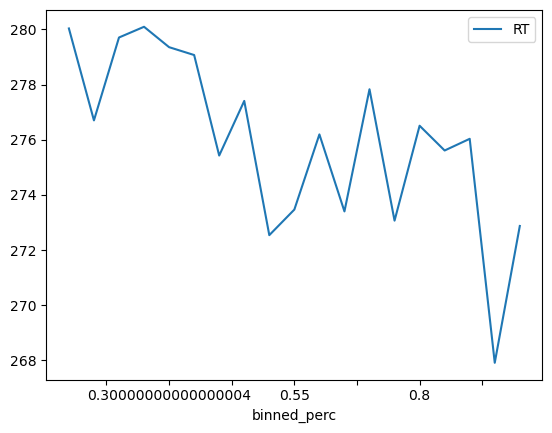

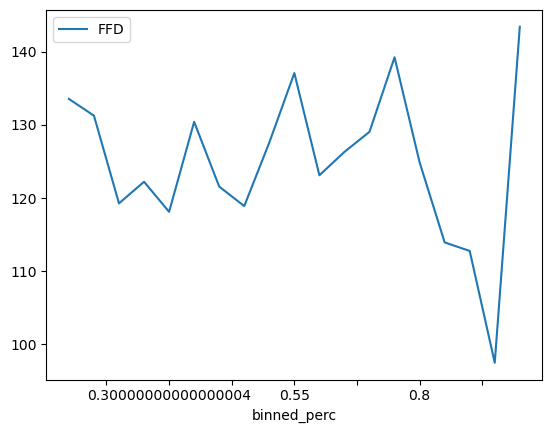

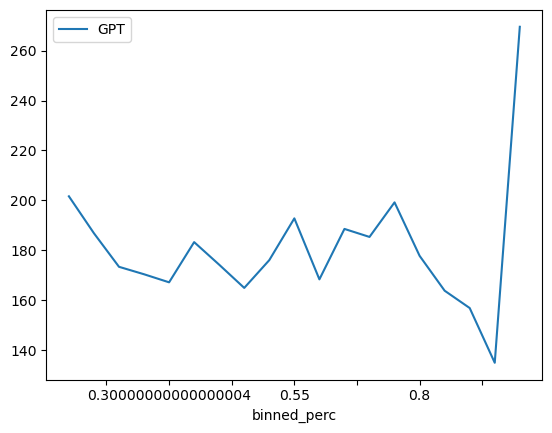

In [356]:
# Now we repeat the plot that shows position against RT metrics with position relative
# to overall sentence length

temp = frank_both_grouped2.copy()
max_pos = temp.groupby(["item"])["zone"].max().reset_index().rename(columns={"zone": "max_zone"})
temp = temp.merge(max_pos, how="inner", on="item")
temp["zone_perc"] = temp["zone"] / temp["max_zone"]

# We make bins
step_size = 0.05
bins = np.arange(0, 1+step_size, step_size)
temp["binned_perc"] = pd.cut(temp['zone_perc'], bins, labels=bins[1:])
temp = temp.groupby("binned_perc").mean(numeric_only=True).reset_index()

temp.plot(x="binned_perc", y="RT")
temp.plot(x="binned_perc", y="FFD")
temp.plot(x="binned_perc", y="GPT")

/tmp/ipykernel_5300/2357119937.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  minmaxnormalise(frank_both_proportional_grouped2.groupby(["binned"])[["surprisal", "RT", "FFD", "GPT", "-zone"]].mean()).plot()


<Axes: xlabel='binned'>

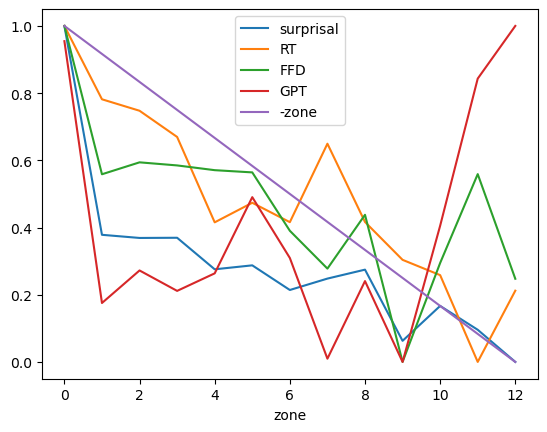

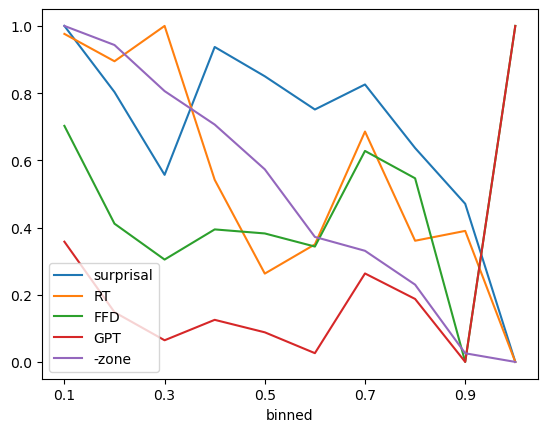

In [357]:
bins = np.arange(0, 11)/10
frank_both_proportional_grouped2['binned'] = pd.cut(frank_both_proportional_grouped2['percent_of_sent'], bins, labels=bins[1:])
frank_both_proportional_grouped2['-zone'] = -frank_both_proportional_grouped2['zone']

minmaxnormalise(frank_both_proportional_grouped2.groupby(["zone"])[["surprisal", "RT", "FFD", "GPT", "-zone"]].mean()).plot()
minmaxnormalise(frank_both_proportional_grouped2.groupby(["binned"])[["surprisal", "RT", "FFD", "GPT", "-zone"]].mean()).plot()

<Axes: xlabel='zone'>

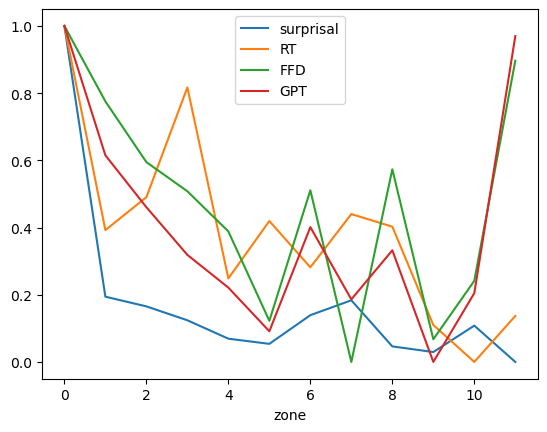

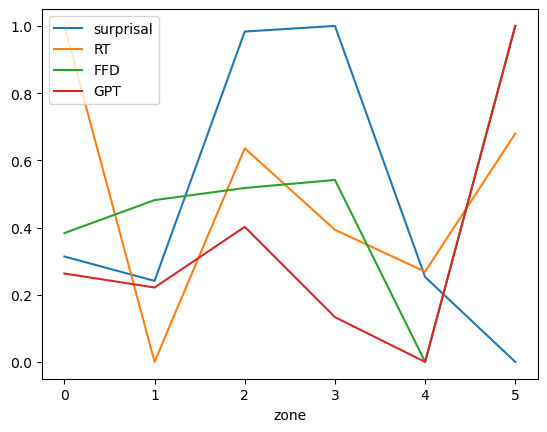

In [358]:
# Let's look at sentences of a specific length

minmaxnormalise(frank_both_proportional_grouped2[frank_both_proportional_grouped2["zone_max"] == 11][["surprisal", "RT", "FFD", "GPT", "zone"]].groupby("zone").mean(numeric_only=True)).plot()
minmaxnormalise(frank_both_proportional_grouped2[frank_both_proportional_grouped2["zone_max"] == 5][["surprisal", "RT", "FFD", "GPT", "zone"]].groupby("zone").mean(numeric_only=True)).plot()

In [359]:
# RT, FFD, GPT seem to have a similar development inside a sentence, except for the end where RT goes down and FFD and GPT goes up.
# Maybe cut off one additional last element?
# The same holds for surprisal.
# We seem to have higher spillover effects for RT (see correlation matrix) while ET metrics are closer to surprisal.

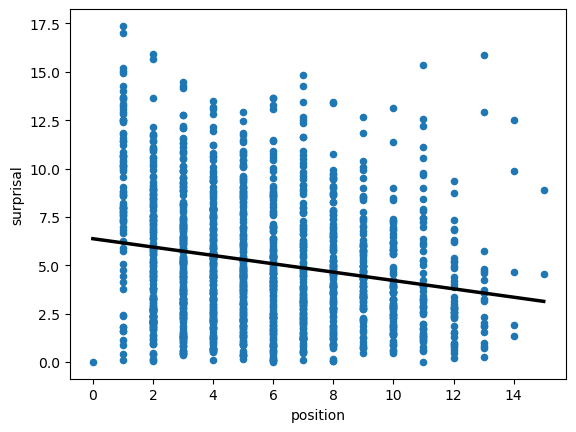

In [360]:
def regression(df: pd.DataFrame, x: str, y: str) -> None:
    fig, ax = plt.subplots()

    df.plot(ax=ax, kind="scatter", x=x, y=y)

    b, a = np.polyfit(df[x], df[y], deg=1)

    # Create sequence of 100 numbers from 0 to 100
    xseq = np.linspace(frank_both_proportional_grouped2[x].min(), frank_both_proportional_grouped2[x].max(), num=100)

    # Plot regression line
    ax.plot(xseq, a + b * xseq, color="k", lw=2.5)

regression(frank_both_proportional_grouped2, "position", "surprisal")

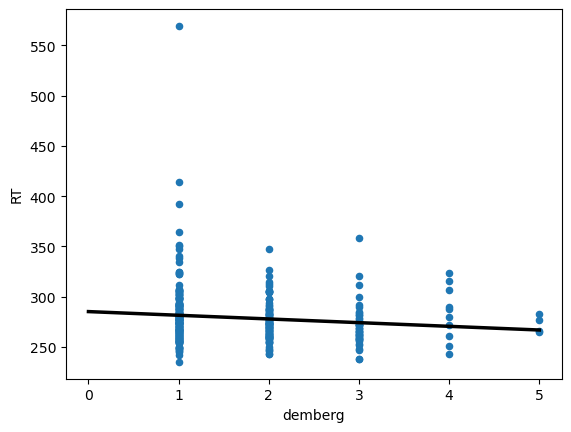

In [361]:
fvb_g = make_grouped(frank_both_proportional2[frank_both_proportional2["pos"] == "VB"], sent_col="item", word_col="position")
regression(fvb_g, "demberg", "RT")

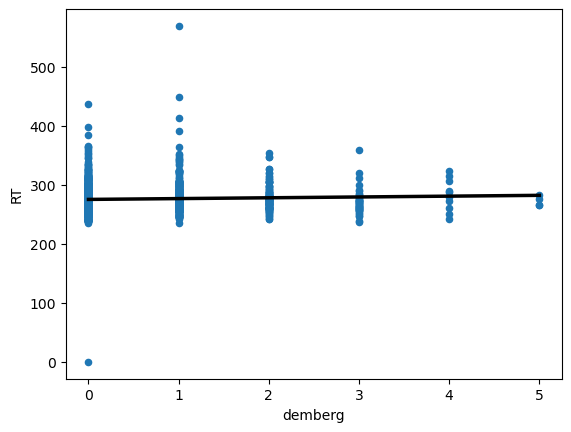

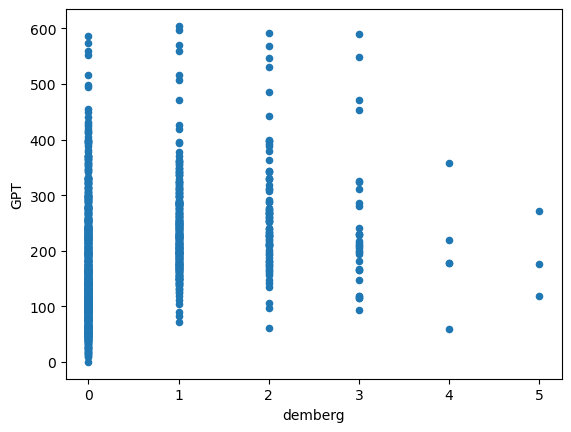

In [362]:
regression(frank_both_proportional_grouped2, "demberg", "RT")
regression(frank_both_proportional_grouped2, "demberg", "GPT")

/tmp/ipykernel_5300/2013034866.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  temp = temp.groupby("binned_RT").mean(numeric_only=True).reset_index()


<Axes: xlabel='binned_RT'>

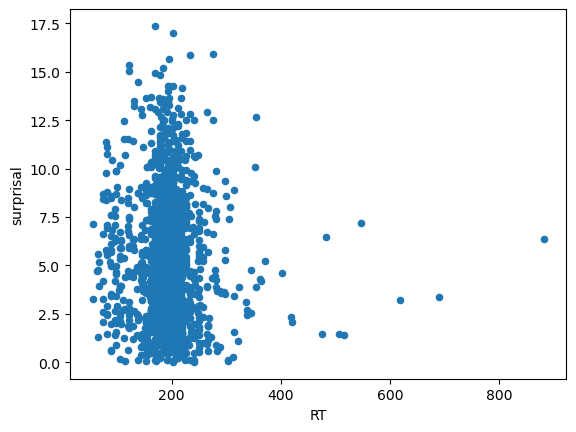

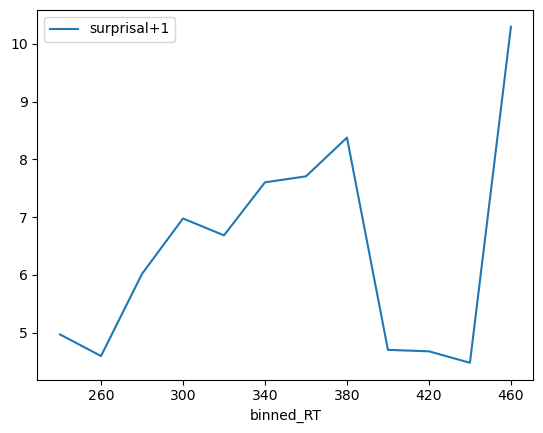

In [363]:
frank_both_proportional2[np.logical_and(frank_both_proportional2["WorkerId"] == 17, frank_both_proportional2["RT"] < 1000)].plot(kind="scatter", x="RT", y="surprisal")
bins = np.arange(0, 500, 20)
temp = frank_both_proportional_grouped2.copy()
pd.cut(frank_both_proportional_grouped2['RT'], bins, labels=bins[1:])
temp["binned_RT"] = pd.cut(frank_both_proportional_grouped2['RT'], bins, labels=bins[1:])
temp = temp.groupby("binned_RT").mean(numeric_only=True).reset_index()
temp.plot(x="binned_RT", y="surprisal+1")


<Axes: xlabel='RT', ylabel='surprisal_n'>

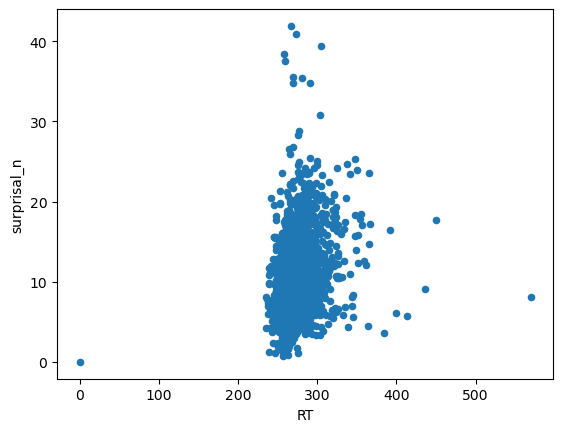

In [364]:
frank_both_proportional_grouped2["surprisal_n"] = frank_both_proportional_grouped2["surprisal"] + frank_both_proportional_grouped2["surprisal+1"]
frank_both_proportional_grouped2.plot(kind="scatter", x="RT", y="surprisal_n")

<Axes: xlabel='position'>

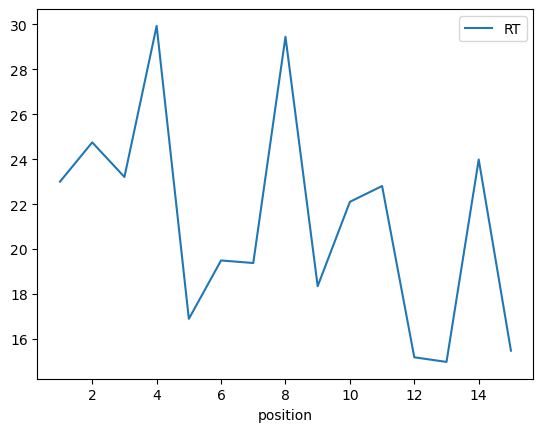

In [365]:
frank_both_proportional_grouped2.groupby(["position"]).std(numeric_only=True).reset_index().plot(x="position", y="RT")

<Axes: xlabel='GPT', ylabel='surprisal'>

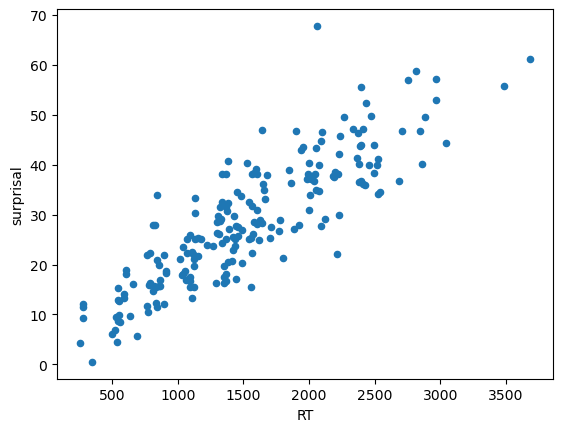

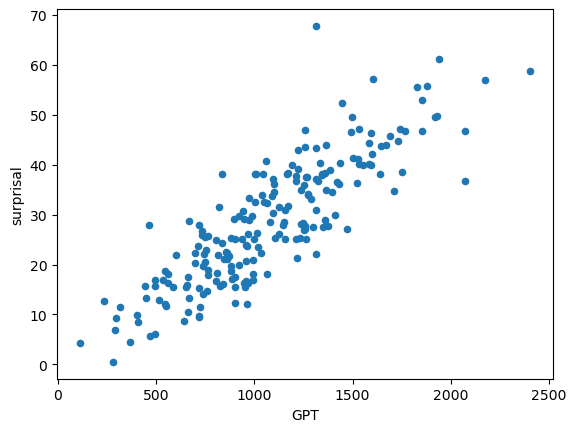

In [366]:
by_item = frank_both_proportional_grouped2.groupby(["item"]).sum(numeric_only=True)
by_item = by_item[by_item["RT"] != 0]
by_item = by_item[by_item["GPT"] != 0]
by_item.plot(kind="scatter", x="RT", y="surprisal")
by_item.plot(kind="scatter", x="GPT", y="surprisal")

/tmp/ipykernel_5300/2492162510.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  minmaxnormalise(frank_both_proportional_grouped2.groupby(["binned"])[["surprisal", "RT", "FFD", "GPT"]].mean()).plot()


<Axes: xlabel='binned'>

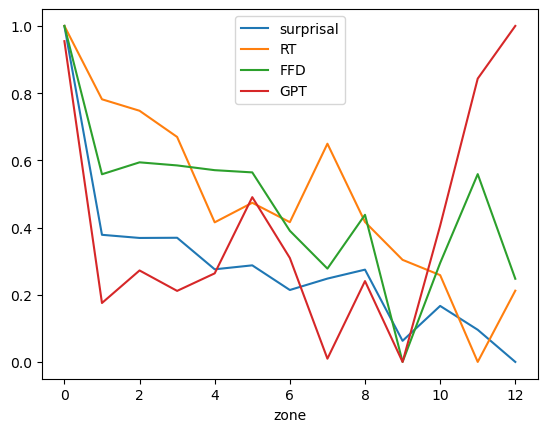

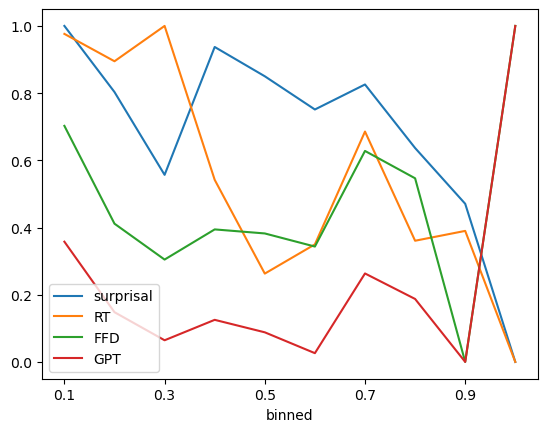

In [367]:
minmaxnormalise(frank_both_proportional_grouped2.groupby(["zone"])[["surprisal", "RT", "FFD", "GPT"]].mean()).plot()
minmaxnormalise(frank_both_proportional_grouped2.groupby(["binned"])[["surprisal", "RT", "FFD", "GPT"]].mean()).plot()

<Axes: xlabel='zone'>

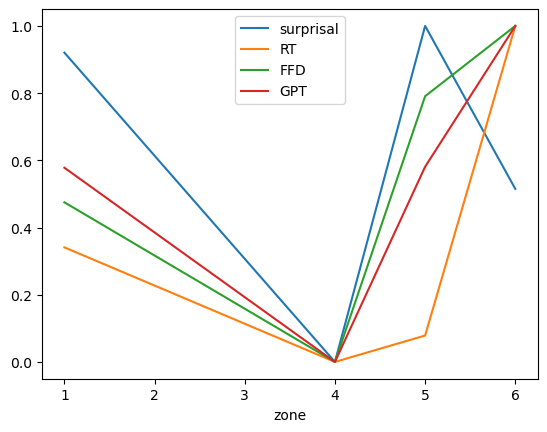

In [368]:
minmaxnormalise(frank_both_proportional_grouped2[frank_both_proportional_grouped2["item"] == 94].groupby(["zone"])[["surprisal", "RT", "FFD", "GPT"]].mean()).plot()

<Axes: xlabel='zone'>

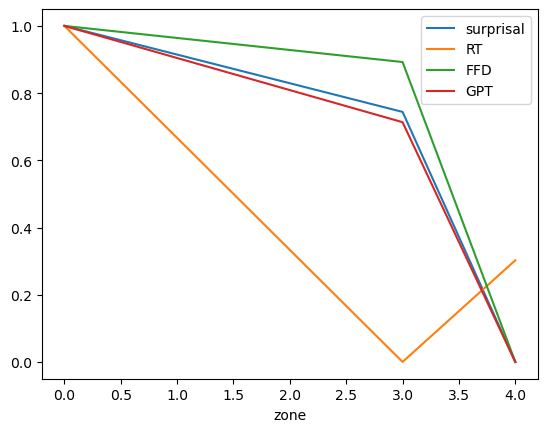

In [369]:
minmaxnormalise(frank_both_proportional_grouped2[frank_both_proportional_grouped2["item"] == 100].groupby(["zone"])[["surprisal", "RT", "FFD", "GPT"]].mean()).plot()

/tmp/ipykernel_5300/3586156789.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  minmaxnormalise(frank_both_proportional_grouped2.groupby(["binned"])[["surprisal", "RT", "FFD", "GPT"]].mean()).plot()


<Axes: xlabel='binned'>

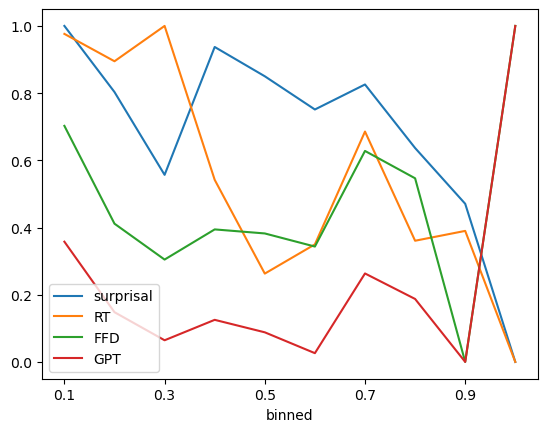

In [370]:
minmaxnormalise(frank_both_proportional_grouped2.groupby(["binned"])[["surprisal", "RT", "FFD", "GPT"]].mean()).plot()

In [371]:
from sklearn import linear_model
from sklearn import preprocessing

temp = frank_both_proportional_grouped2.dropna(subset=["surprisal"])
X = temp[["surprisal"]]
y = temp[["RT"]]

lm = linear_model.LinearRegression()
reg = linear_model.LinearRegression().fit(X, y)
preds = reg.predict(X)
reg.score(X, y)

0.022976729585884037

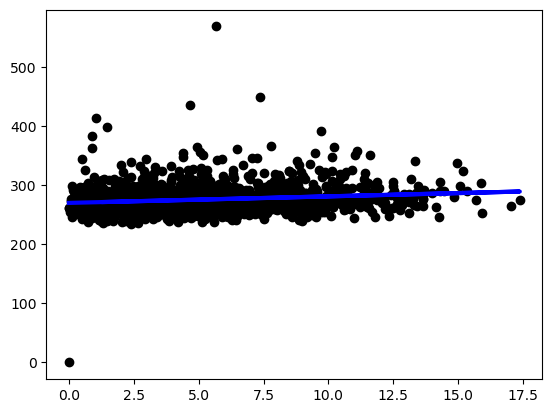

In [372]:
plt.scatter(X, y, color="black")
plt.plot(X, preds, color="blue", linewidth=3)

plt.show()

In [373]:
X = temp[["surprisal"]]

poly = preprocessing.PolynomialFeatures(2)
X = poly.fit_transform(X)

reg = linear_model.LinearRegression().fit(X, y)
reg.score(X, y)

0.02367775472739153

In [374]:
X = temp[["surprisal+1"]]

poly = preprocessing.PolynomialFeatures(2)
X = poly.fit_transform(X)

reg = linear_model.LinearRegression().fit(X, y)
reg.score(X, y)

0.03867175479552154

In [375]:
X = temp[["surprisal", "surprisal+1"]]

poly = preprocessing.PolynomialFeatures(2)
X = poly.fit_transform(X)

reg = linear_model.LinearRegression().fit(X, y)
reg.score(X, y)

0.06454439901229359

In [376]:
X = temp[["surprisal", "surprisal+1", "position", "demberg", "demberg+1", "demberg-1"]]

poly = preprocessing.PolynomialFeatures(2)
X = poly.fit_transform(X)

reg = linear_model.LinearRegression().fit(X, y)
reg.score(X, y)

0.07536423194705211

In [377]:
# Analyse the errors made by the linear regression to find out where surprisal underexplains

temp = frank_both_proportional_grouped2.dropna(subset=["surprisal"])
X = temp[["surprisal"]]
y = temp[["RT"]]

lm = linear_model.LinearRegression()
reg = linear_model.LinearRegression().fit(X, y)
error = reg.predict(X) - y

columns = temp.select_dtypes(include=[np.number]).dropna(axis="columns").columns
results = []
for column in columns:
    X2 = temp[[column]]
    lm2 = linear_model.LinearRegression()
    reg2 = linear_model.LinearRegression().fit(X2, error)
    results.append(reg2.score(X2, error))

pd.DataFrame({"column": columns, "score": [round(value, 3) for value in results]})


,column,score
0,item,0.000
1,position,0.004
2,zone,0.006
3,WorkerId,0.003
4,frequency,0.002
5,length,0.004
6,surprisal,0.000
7,head_distance,0.004
8,fdd,0.001
9,ldds,0.001
